<font face = "Verdana" size ="3">Coronavirus is actually a family of viruses rather than a that are named out of their spiky crown. The novel coronavirus, also known as SARS-CoV-2, is a contagious respiratory virus that first reported in Wuhan, China. On 02/11/2020, the World Health Organization designated the name COVID-19 for the disease caused by the novel coronavirus. Our project is aiming at training different model we learned in this quarter to fit and predict the data of COVID-19.
 
   <br><br>Data is provided by <a href='https://github.com/CSSEGISandData/COVID-19'>Johns Hopkins University</a>

   <font face = "Verdana" size ="1">
    <center><img src='https://www.statnews.com/wp-content/uploads/2020/02/Coronavirus-CDC-645x645.jpg'>
     Source: https://www.statnews.com/wp-content/uploads/2020/02/Coronavirus-CDC-645x645.jpg </center> 
    </font>

In [1]:
import pandas as pd 
import random
import math
import time
import xgboost
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from autograd.misc.flatten import flatten_func
from autograd import grad
from autograd import hessian
from autograd import numpy as np
import math
import copy

# import custom utilities
import custom_utilities as util

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%matplotlib notebook
%load_ext autoreload
%autoreload 2

print("Success!")

Success!


Import the COVID-19 data and check their availability

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/06-02-2020.csv')
us_medical_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/06-02-2020.csv')

In [3]:
latest_data.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,45001.0,Abbeville,South Carolina,US,2020-06-03 02:33:13,34.223334,-82.461707,46,0,0,46,"Abbeville, South Carolina, US",187.548416,0.000000
1,22001.0,Acadia,Louisiana,US,2020-06-03 02:33:13,30.295065,-92.414197,428,24,0,404,"Acadia, Louisiana, US",689.821903,5.607477
2,51001.0,Accomack,Virginia,US,2020-06-03 02:33:13,37.767072,-75.632346,939,12,0,927,"Accomack, Virginia, US",2905.681396,1.277955
3,16001.0,Ada,Idaho,US,2020-06-03 02:33:13,43.452658,-116.241552,818,22,0,796,"Ada, Idaho, US",169.855083,2.689487
4,19001.0,Adair,Iowa,US,2020-06-03 02:33:13,41.330756,-94.471059,9,0,0,9,"Adair, Iowa, US",125.838926,0.000000


In [4]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,10582,11173,11831,12456,13036,13659,14525,15205,15750,16509
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,998,1004,1029,1050,1076,1099,1122,1137,1143,1164
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,8306,8503,8697,8857,8997,9134,9267,9394,9513,9626
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,762,763,763,763,763,764,764,764,765,844
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,69,70,70,71,74,81,84,86,86,86


In [5]:
us_medical_data.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-06-03 02:33:21,32.3182,-86.9023,18766,653,9355.0,8758.0,1,382.730817,223802.0,1879.0,3.479697,84000001,USA,4564.420882,10.012789
1,Alaska,US,2020-06-03 02:33:21,61.3707,-152.4044,486,10,371.0,105.0,2,66.434737,56203.0,NaN,2.057613,84000002,USA,7682.780964,NaN
2,American Samoa,US,2020-06-03 02:33:21,-14.2710,-170.1320,0,0,NaN,0.0,60,0.000000,174.0,NaN,NaN,16,ASM,312.719038,NaN
3,Arizona,US,2020-06-03 02:33:21,33.7298,-111.4312,21264,943,4967.0,15354.0,4,292.139398,237833.0,3057.0,4.434725,84000004,USA,3267.512667,14.376411
4,Arkansas,US,2020-06-03 02:33:21,34.9697,-92.3731,7818,136,5401.0,2281.0,5,259.062550,133236.0,718.0,1.739575,84000005,USA,4414.998456,9.183935


In [7]:
cols = confirmed_df.keys()
cols

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '5/24/20', '5/25/20', '5/26/20', '5/27/20', '5/28/20', '5/29/20',
       '5/30/20', '5/31/20', '6/1/20', '6/2/20'],
      dtype='object', length=137)

Because the tendency may vary from different country or region because of different epidemic prevention policy, we would only focus on predicting the tendency of America.

In [8]:
confirmed_us = confirmed_df.loc[confirmed_df['Country/Region'] == 'US', :]
confirmed_us

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20
225,NaN,US,37.0902,-95.7129,1,1,2,2,5,5,...,1643246,1662302,1680913,1699176,1721753,1746019,1770165,1790172,1811020,1831821


In [9]:
deaths_us = deaths_df.loc[deaths_df['Country/Region'] == 'US', :]
deaths_us

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20
225,NaN,US,37.0902,-95.7129,0,0,0,0,0,0,...,97719,98219,98912,100417,101616,102809,103776,104381,105149,106180


In [10]:
recover_us = recoveries_df.loc[recoveries_df['Country/Region'] == 'US', :]
recover_us

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20
225,NaN,US,37.0902,-95.7129,0,0,0,0,0,0,...,366736,379157,384902,391508,399991,406446,416461,444758,458231,463868



Get all the dates for the outbreak

In [11]:
confirmed = confirmed_us.loc[:, cols[4]:cols[-1]]
deaths = deaths_us.loc[:, cols[4]:cols[-1]]
recover = recover_us.loc[:, cols[4]:cols[-1]]

confirmed

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20
225,1,1,2,2,5,5,5,5,5,7,...,1643246,1662302,1680913,1699176,1721753,1746019,1770165,1790172,1811020,1831821


In [ ]:
# confirmed_us = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
# death_us = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

In [12]:
dates = confirmed.keys()

us_cases = []
us_deaths = [] 
us_recoveries = [] 

for i in dates:
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    
    us_deaths.append(deaths_df[deaths_df['Country/Region']=='US'][i].sum())
    
    us_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='US'][i].sum())

Getting daily increases

In [13]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

us_daily_increase = daily_increase(us_cases)
us_daily_death = daily_increase(us_deaths)
us_daily_recovery = daily_increase(us_recoveries)

days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)

Future forcasting

In [14]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

Convert integer into datetime for better visualization

In [164]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [15]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, us_cases, test_size=0.3, shuffle=False) 

Model for predicting confirmed cases of US. I am using linear regression, polynomial regression,  SVM and neural network in this example. And compare their performance.

## First, let us use <em>Linear Regression</em> to predict

The time cost for training is 0:00:00.001995


<IPython.core.display.Javascript object>


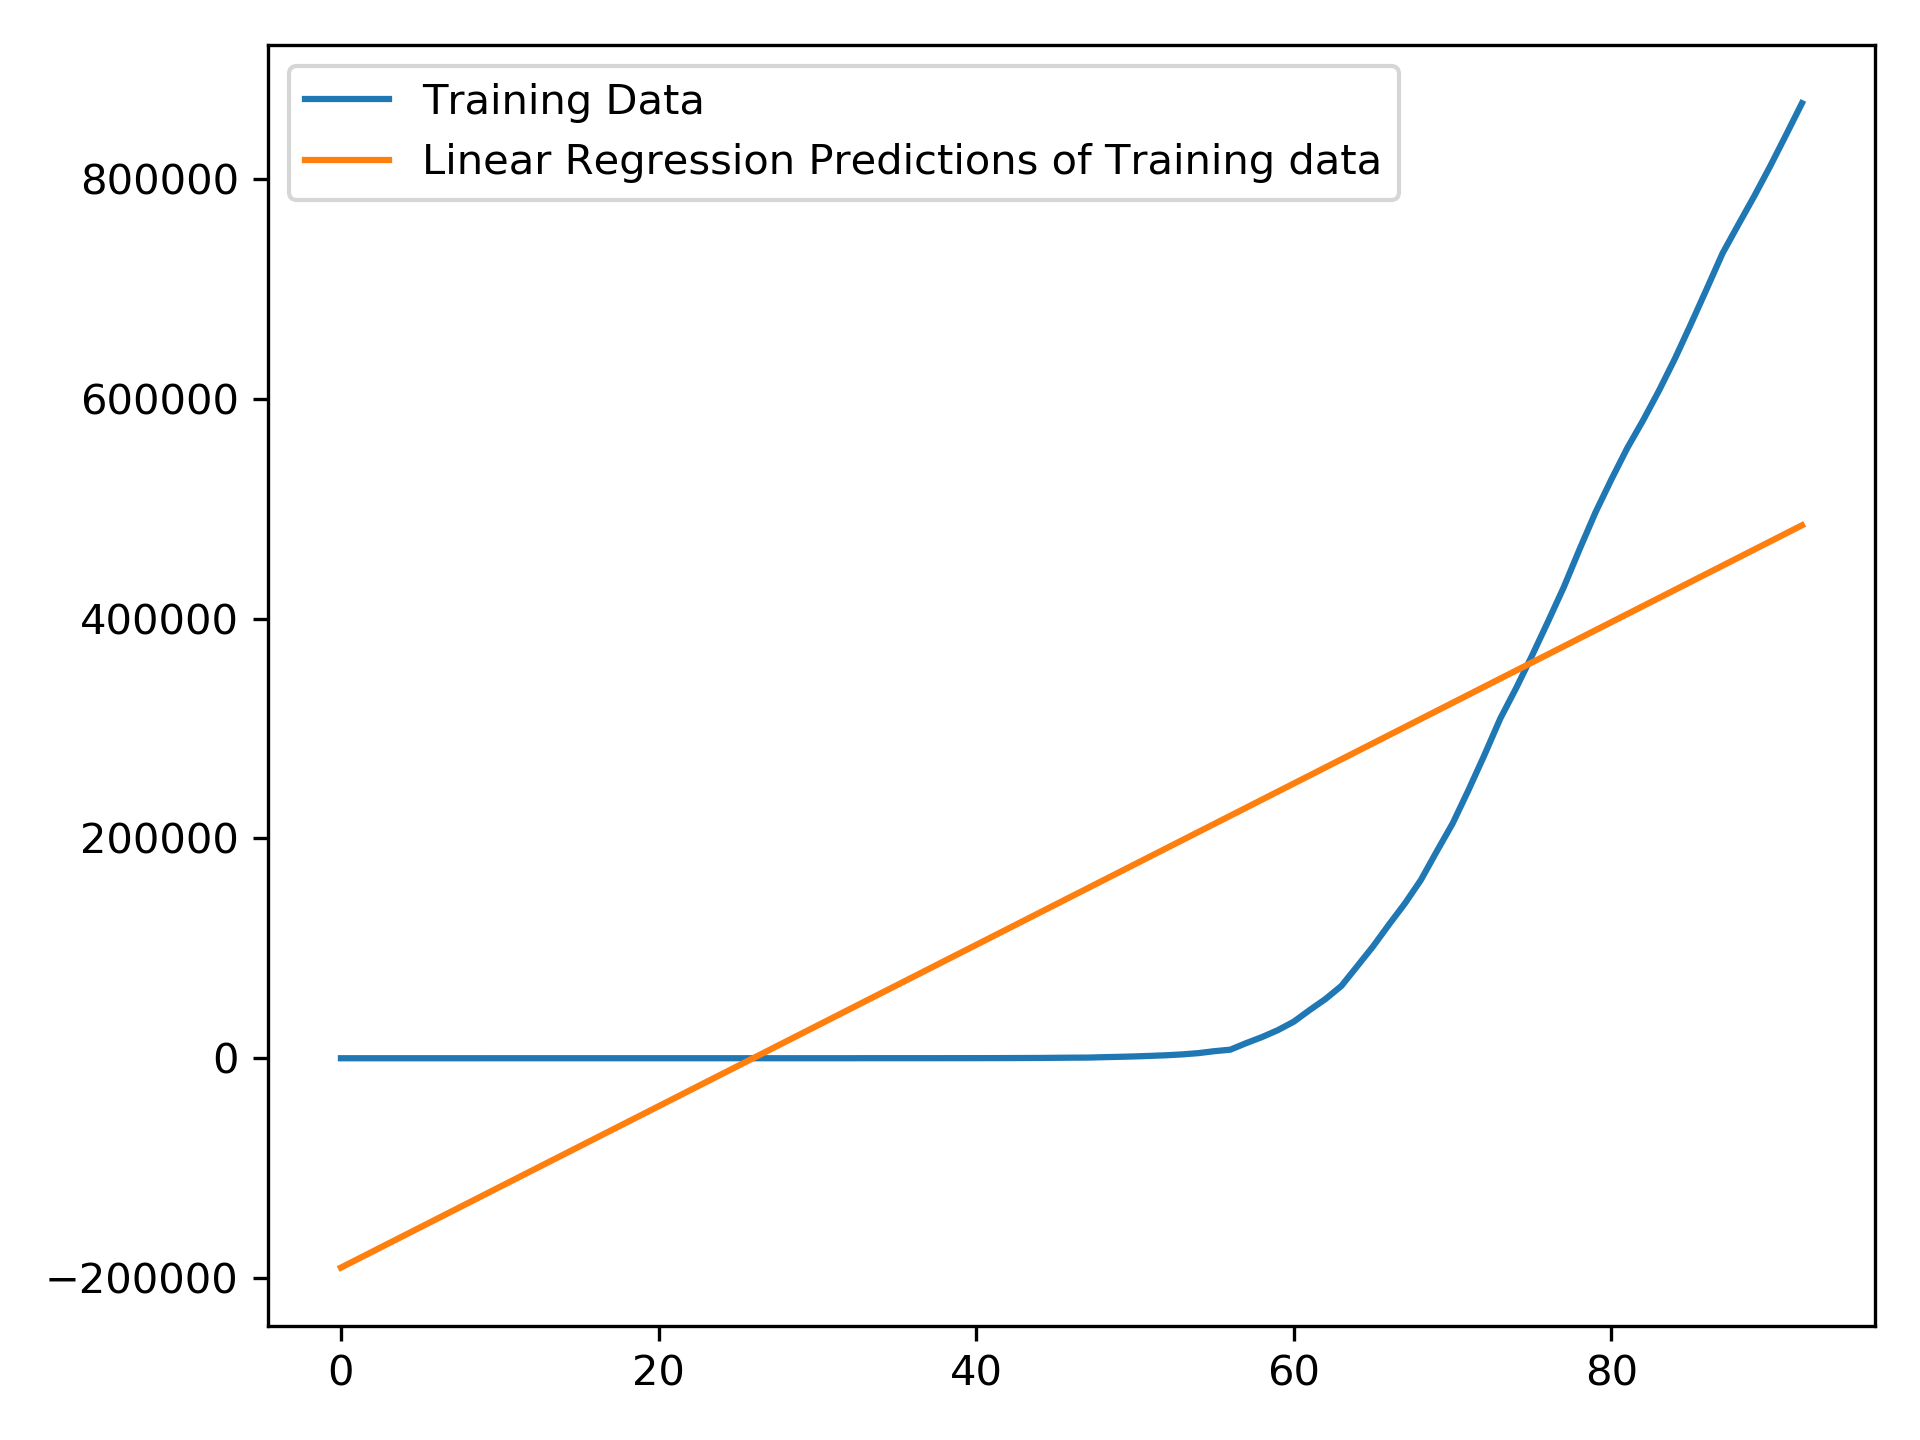

In [16]:
start_time = datetime.datetime.now() 
reg = LinearRegression().fit(X_train_confirmed, y_train_confirmed)
end_time = datetime.datetime.now()

print("The time cost for training is {}".format(end_time - start_time))

linear_test_pred = reg.predict(X_test_confirmed)

linear_train_pred = reg.predict(X_train_confirmed)

plt.plot(y_train_confirmed)
plt.plot(linear_train_pred)
plt.legend(['Training Data', 'Linear Regression Predictions of Training data'])

<IPython.core.display.Javascript object>


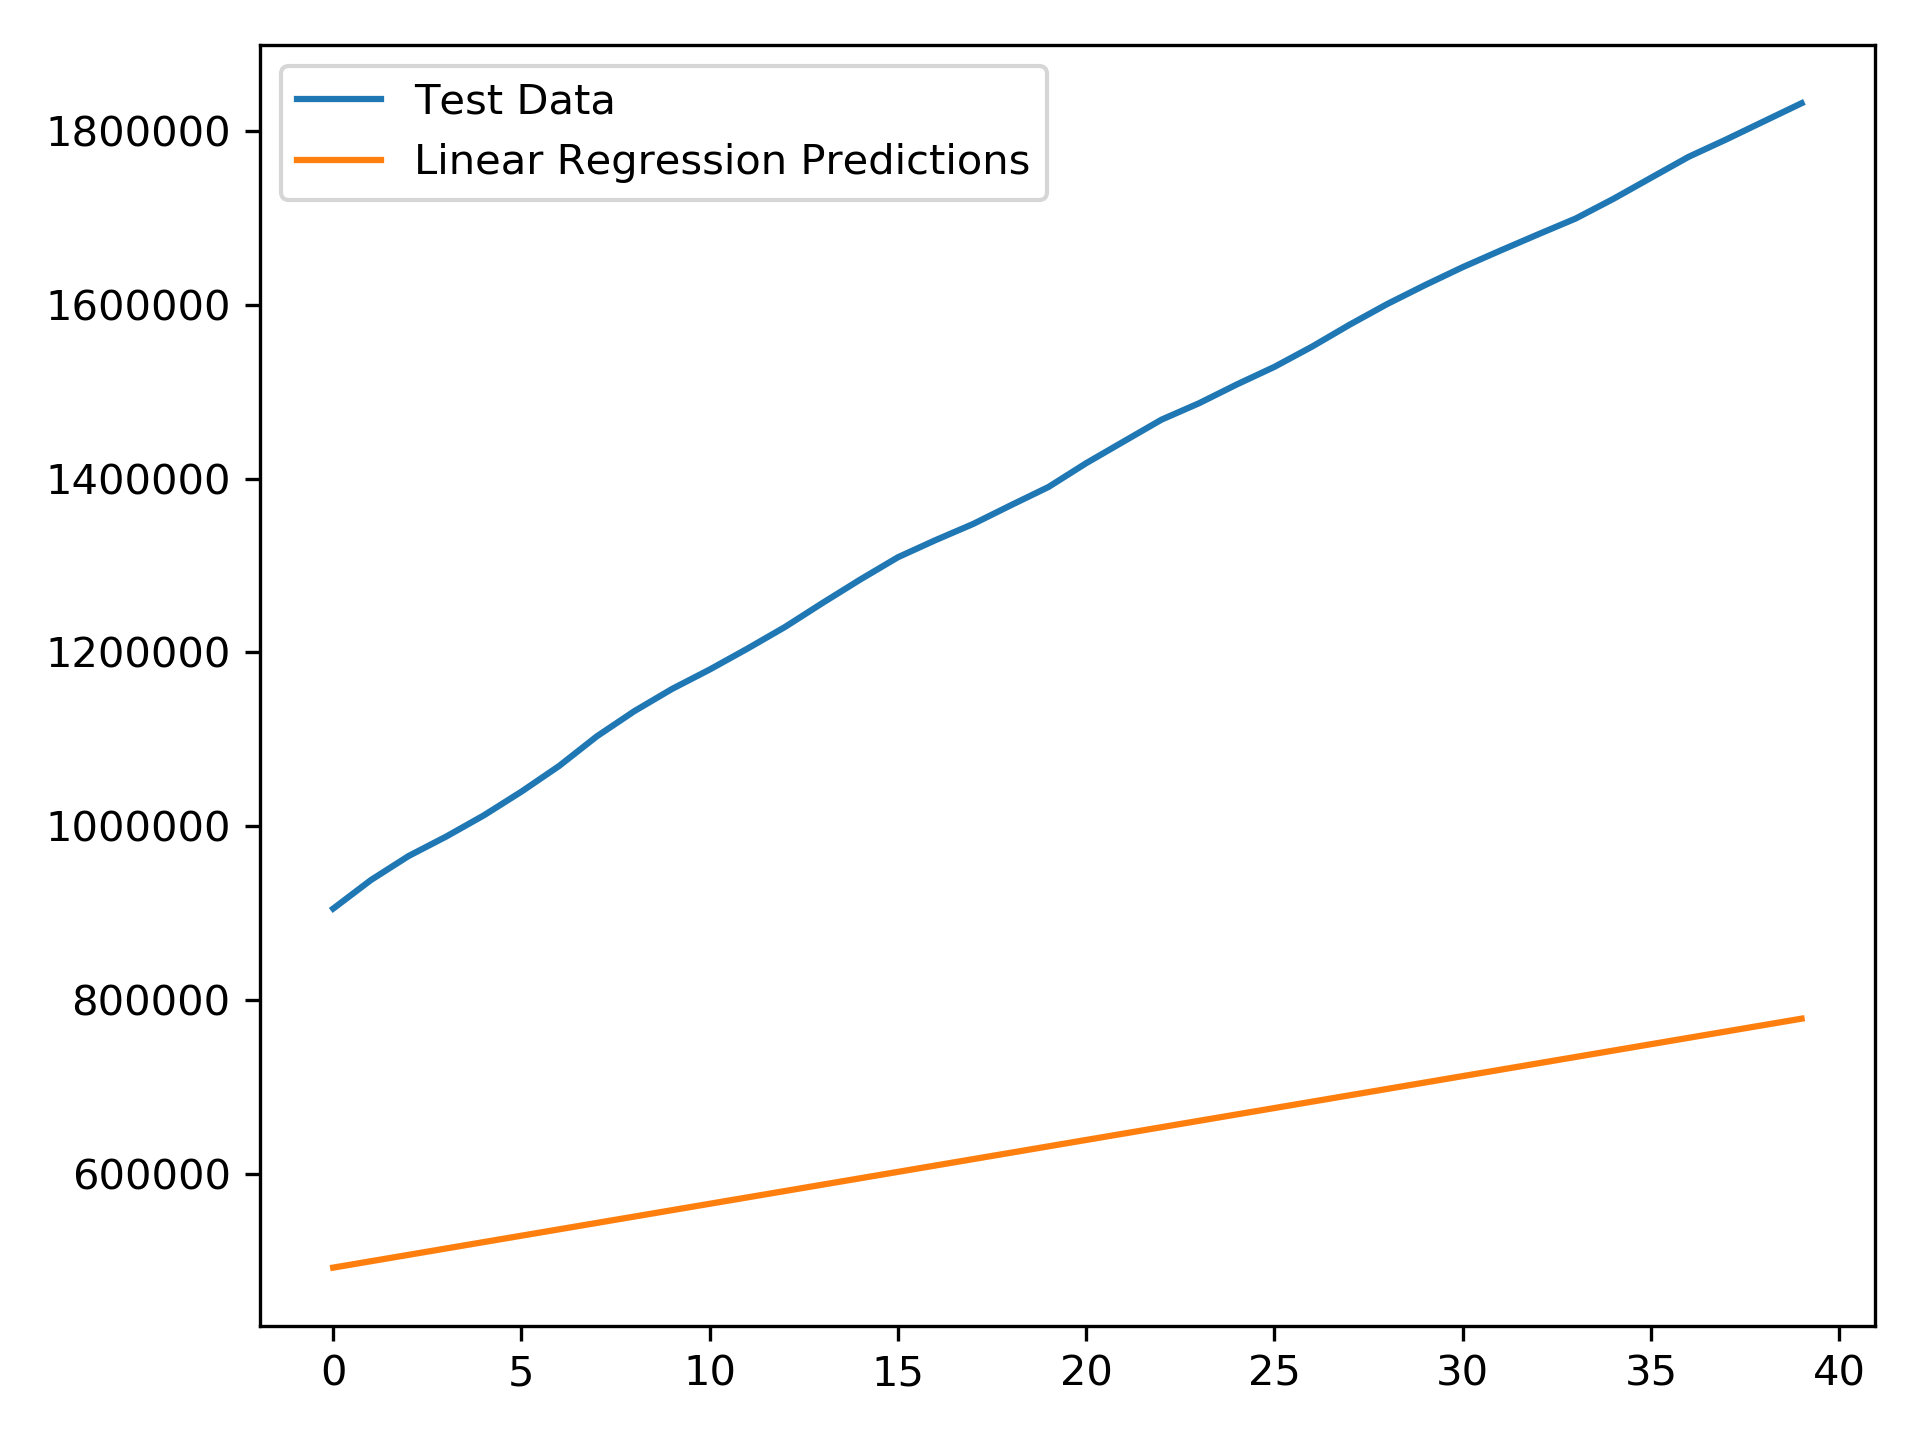

In [17]:
plt.plot(y_test_confirmed)
plt.plot(linear_test_pred)
plt.legend(['Test Data', 'Linear Regression Predictions'])

In [18]:
print('MAE:', mean_absolute_error(linear_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(linear_test_pred, y_test_confirmed))

linear_future_pred = reg.predict(future_forcast)

MAE: 758854.4930281602
MSE: 610634604374.5104


Seen from the two graphs, we easily notice that by simply applying linear model to fit the data is not good enough, it is because the linear model itself does not contain any non-linearity.
Although this method is fast to train and also predict which cost only 0.001995 seconds to train, simple Linear regression can never be a good choice. We would also quantitatively compare the performance by the MAE/MSE shown above.

## Second, we go further and use <em>Polynomial Regression</em> to predict

In [39]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree = 3)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

# polynomial regression
poly_model = LinearRegression(normalize=True, fit_intercept=False)

start_time = datetime.datetime.now() 
poly_model.fit(poly_X_train_confirmed, y_train_confirmed)
end_time = datetime.datetime.now() 

print("The time cost for training is {}".format(end_time - start_time))

poly_train_pred = poly_model.predict(poly_X_train_confirmed)
poly_test_pred = poly_model.predict(poly_X_test_confirmed)
poly_future_pred = poly_model.predict(poly_future_forcast)

The time cost for training is 0:00:00.000998


<IPython.core.display.Javascript object>


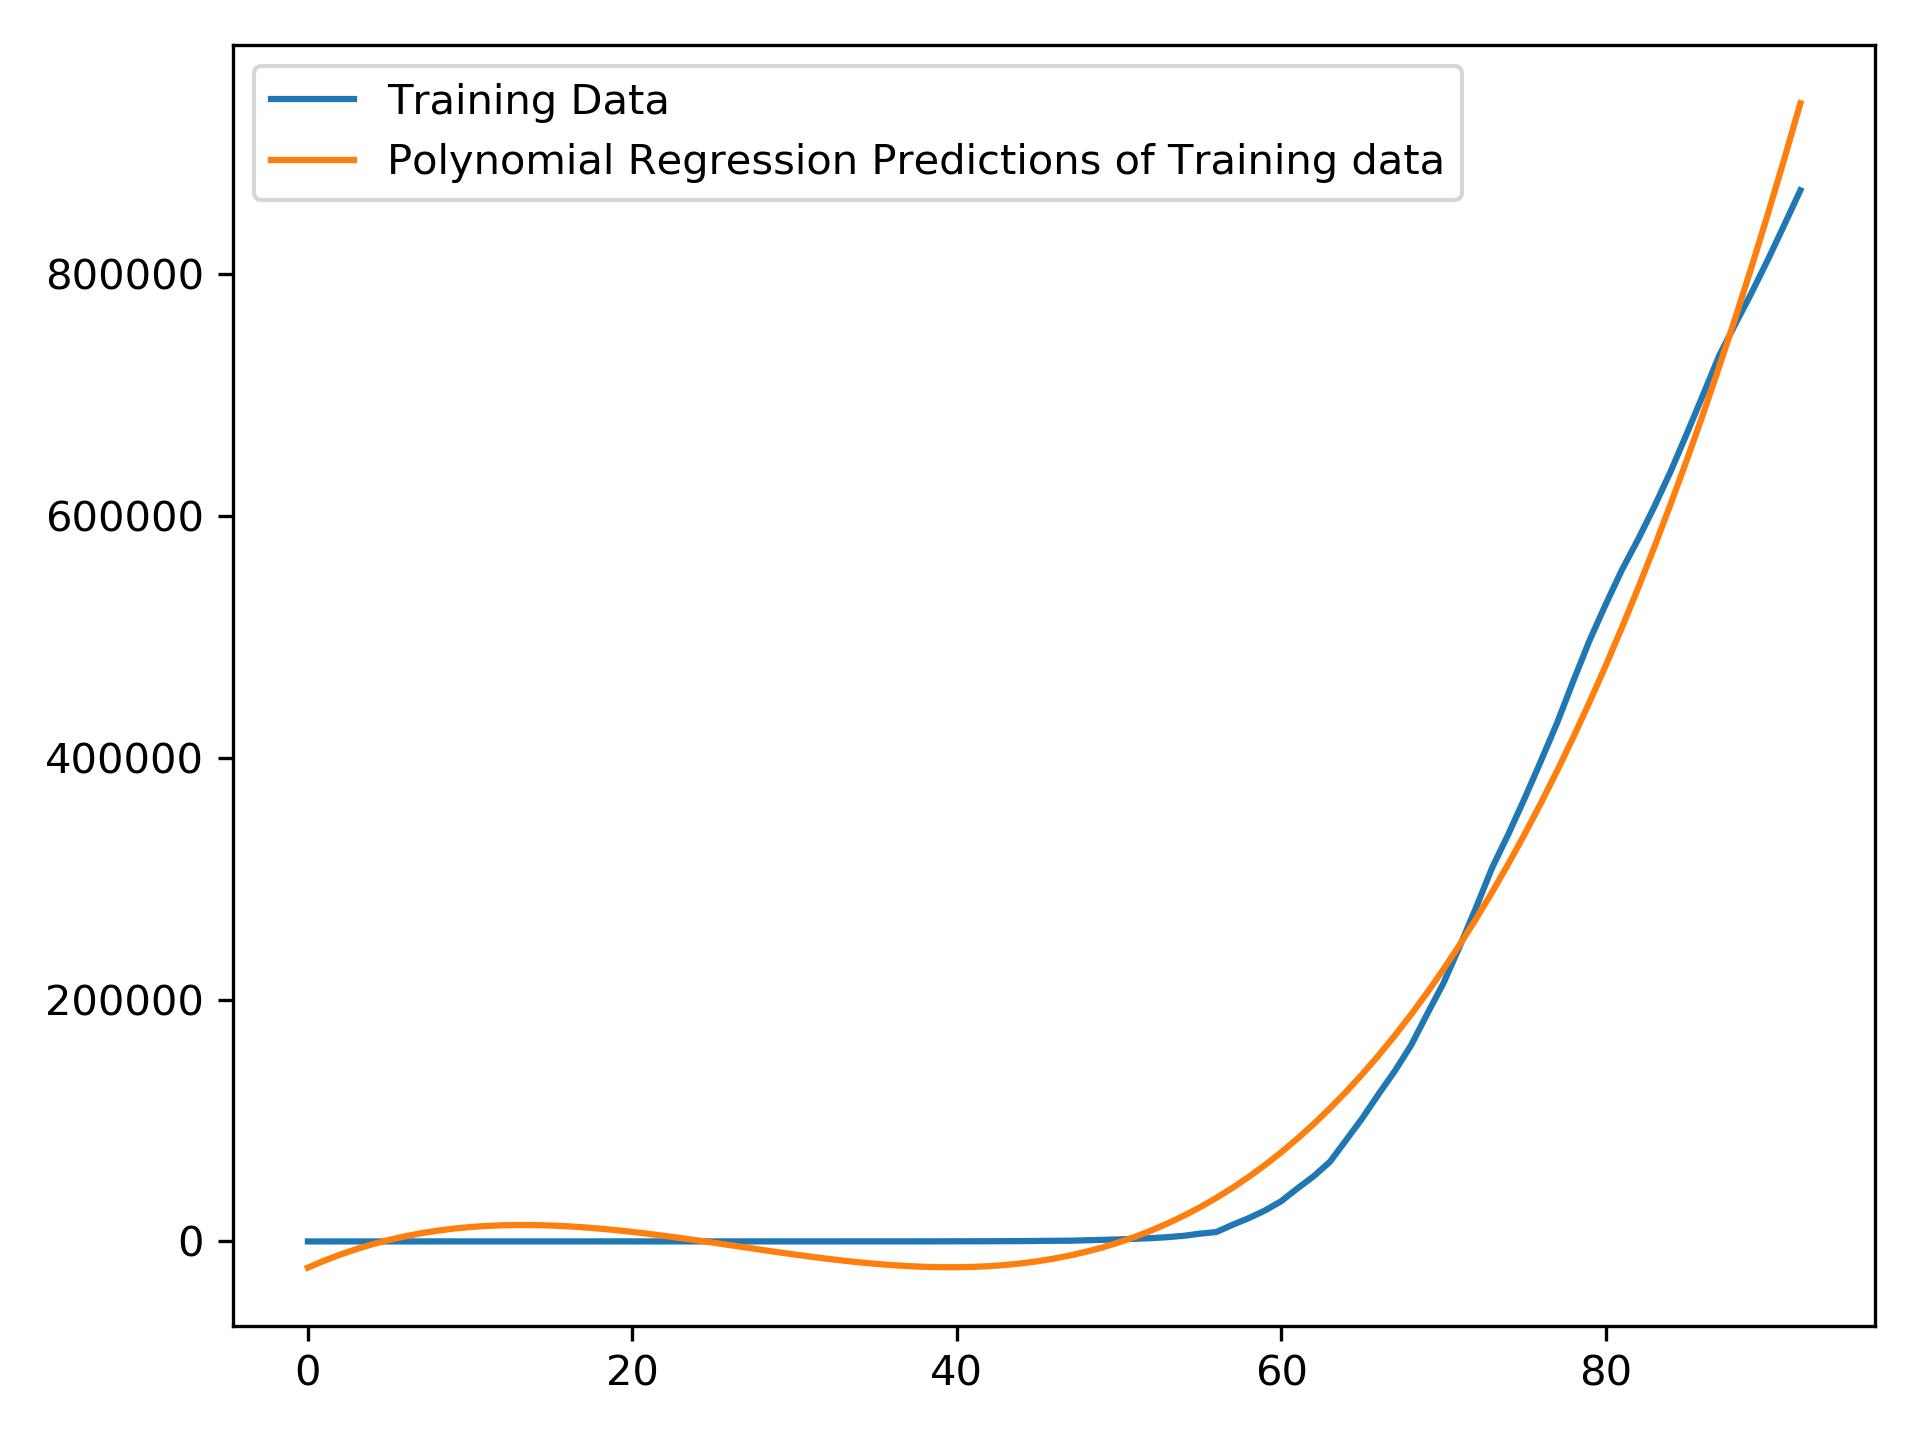

In [40]:
plt.plot(y_train_confirmed)
plt.plot(poly_train_pred)
plt.legend(['Training Data', 'Polynomial Regression Predictions of Training data'])

<IPython.core.display.Javascript object>


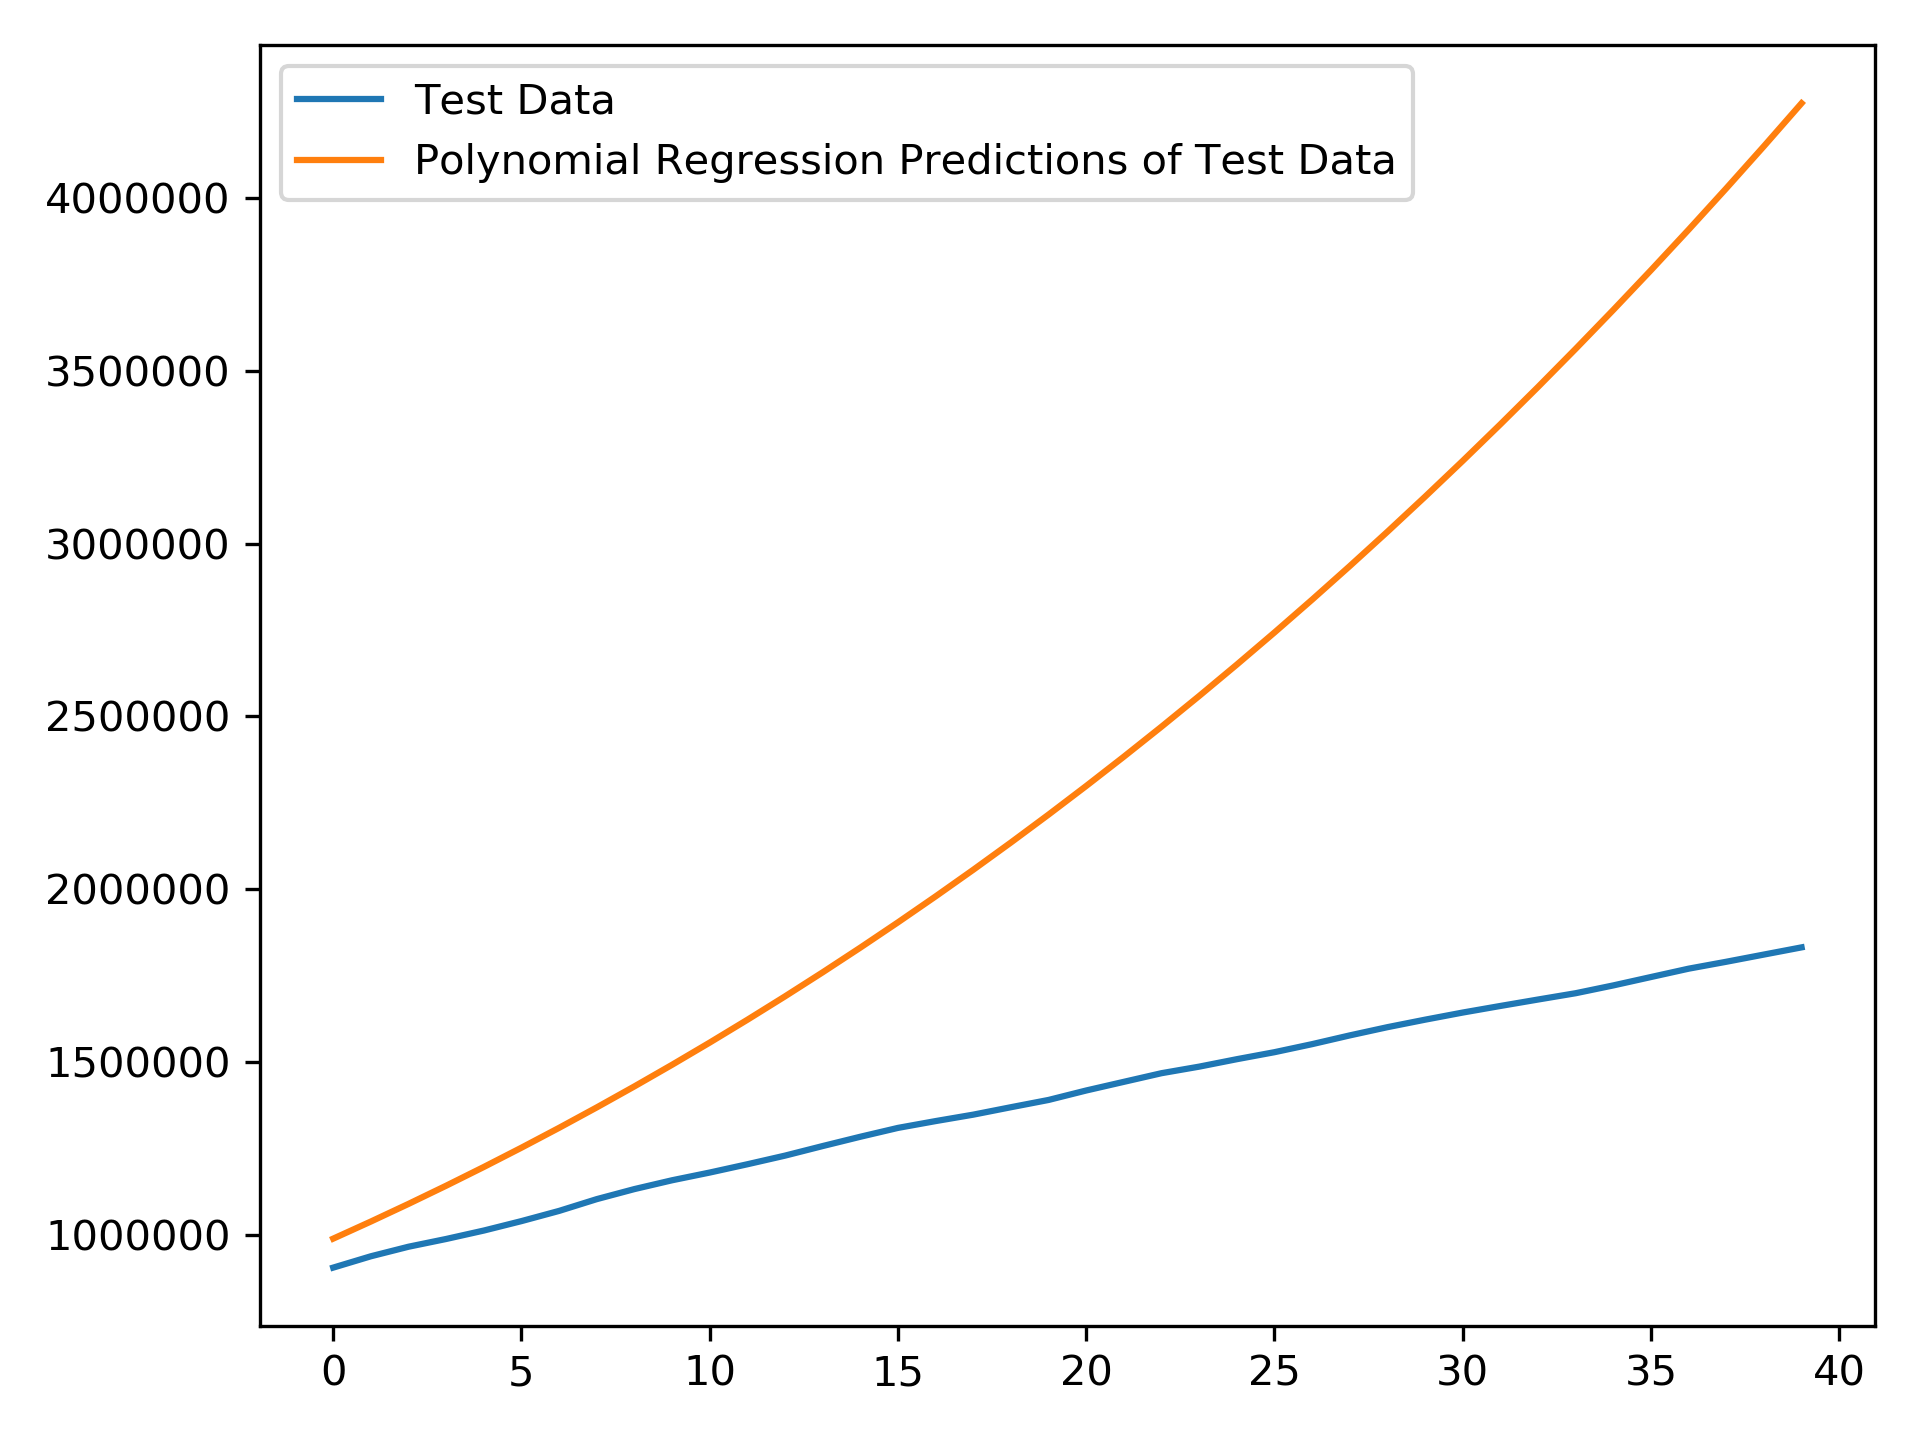

In [41]:
plt.plot(y_test_confirmed)
plt.plot(poly_test_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions of Test Data'])

In [42]:
print('MAE:', mean_absolute_error(poly_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(poly_test_pred, y_test_confirmed))

MAE: 993907.7282200744
MSE: 1488171355226.293


Seen from the 2 graphs,  we can tell that by applying polynomial model to fit the data is roughly good enough in the training dataset, but performs so bad in the test dataset. It is not just out of overfitting, but also because during the initial period of pandemic, its tendency follows exponantil law. When the total number of confirmed cases reaches a point, because of the limitation of total population and epidemic prevention policy, it will not increase that rapidly.
In this case, we use 3-degree polynomial regression, it is trained similarly with linear regression and trained similarly fast which is 0.000998 second. We also tried 2-degree which is underfitting and when degree is over 4, it can be extremely overfitting so we do not show them here.

## Third, we try to use <em>SVM</em> to predict

In [ ]:
# # use this to find the optimal parameters for SVR
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
degree = [3, 4, 5]

svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

svm = SVR(kernel='poly')
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
svm_search.fit(X_train_confirmed, y_train_confirmed)

svm_search.best_params_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s


In [60]:
svm_model = SVR(shrinking=True, kernel='poly', gamma=0.01, epsilon=0.1, degree=4, C=0.01)

start_time = datetime.datetime.now() 
svm_model.fit(X_train_confirmed, y_train_confirmed)
end_time = datetime.datetime.now() 
print("The time cost for training is {}".format(end_time - start_time))

svm_test_pred = svm_model.predict(X_test_confirmed)

svm_train_pred = svm_model.predict(X_train_confirmed)

svm_future_pred = svm_model.predict(future_forcast)

The time cost for training is 0:00:00.007979


<IPython.core.display.Javascript object>


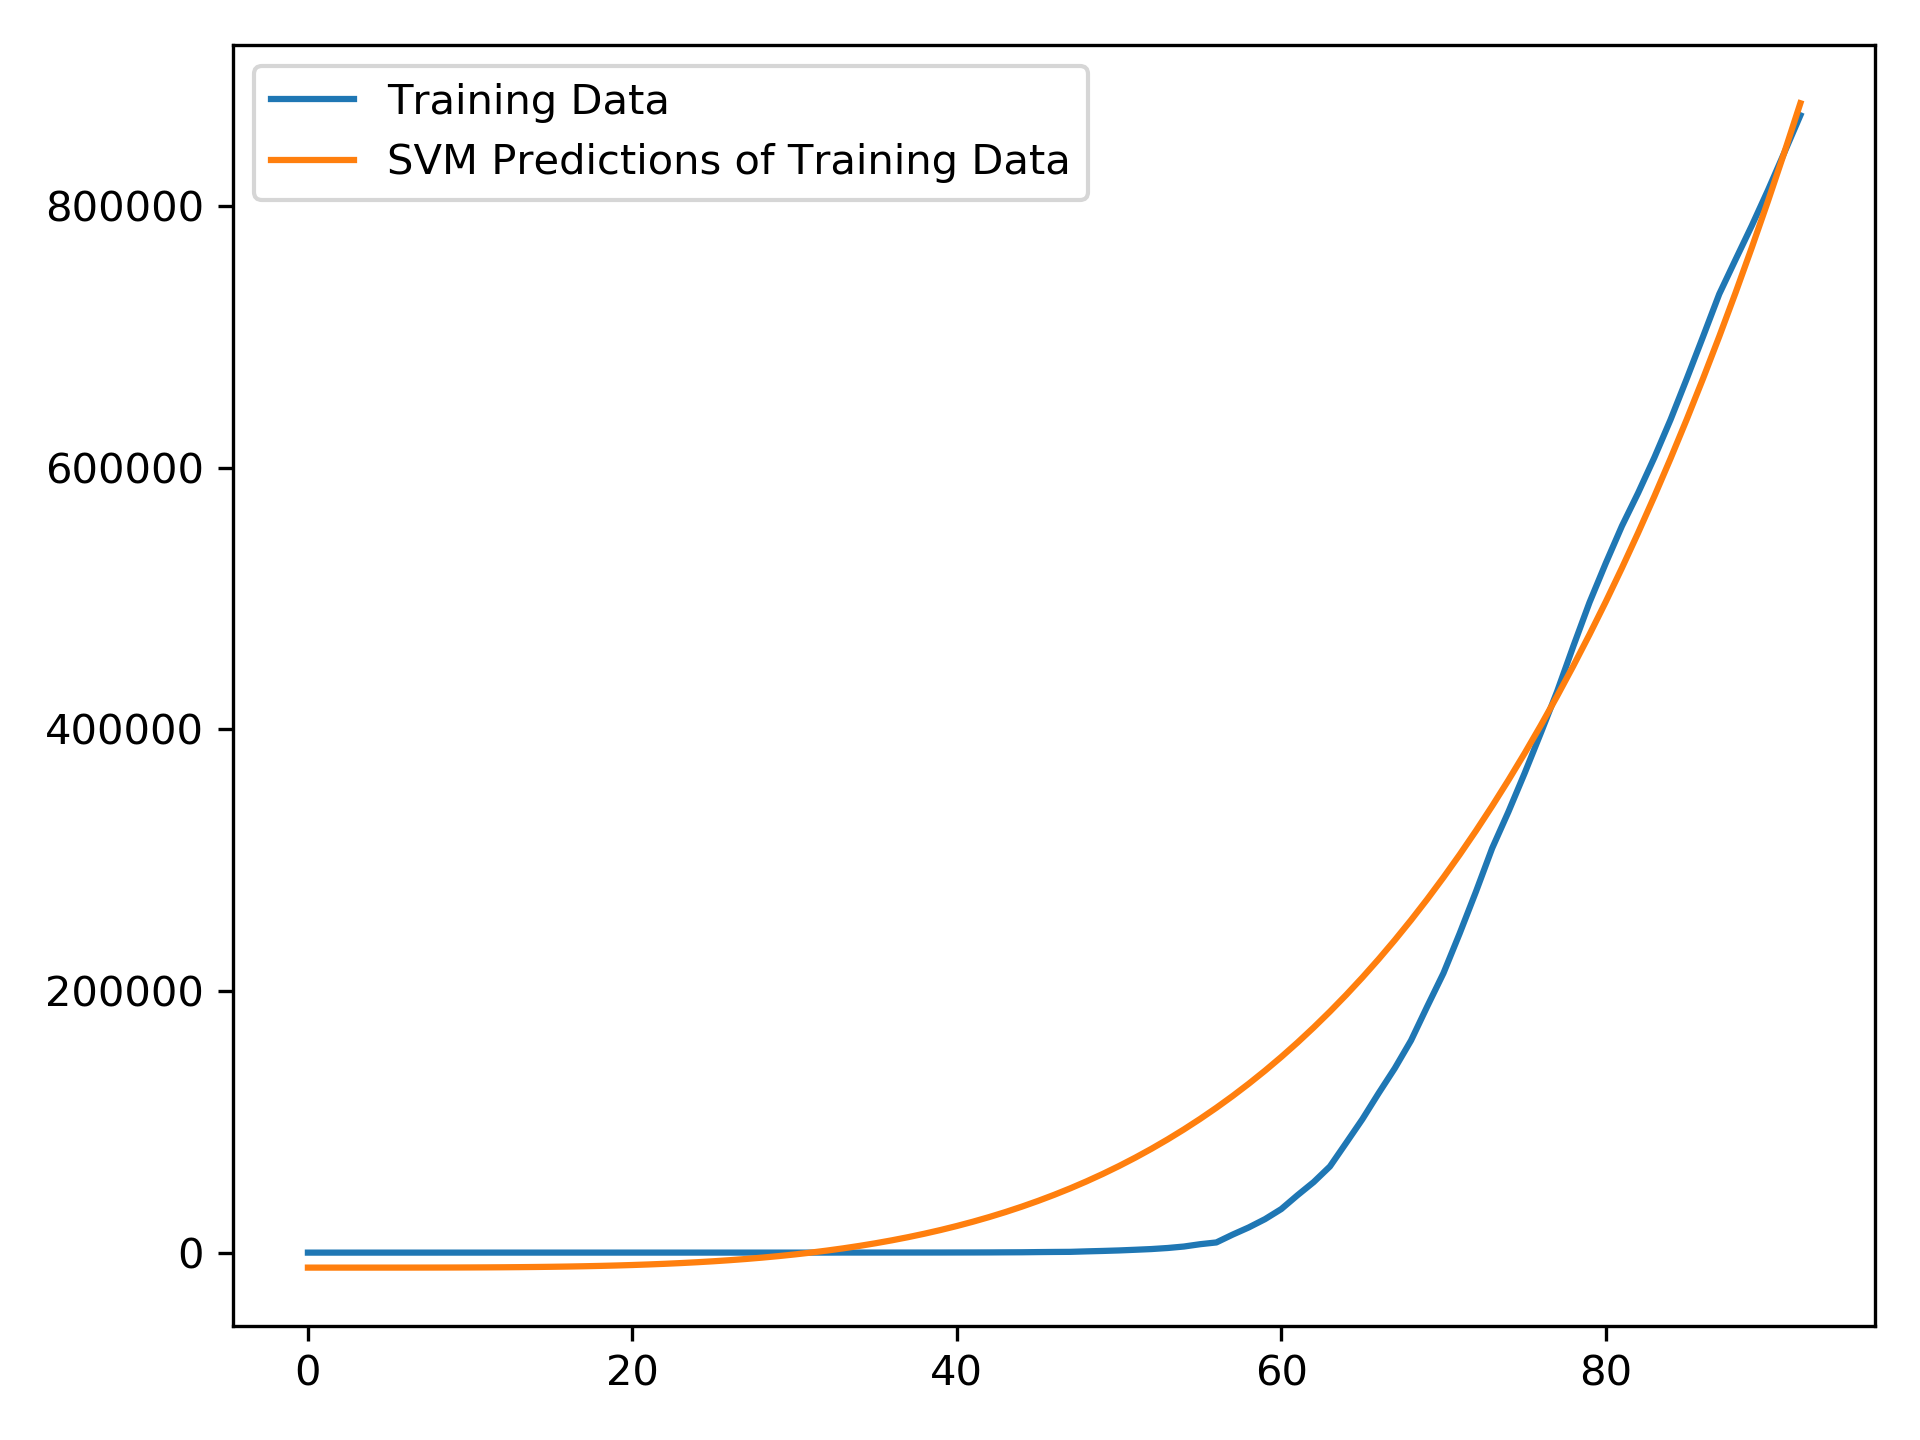

In [61]:
plt.plot(y_train_confirmed)
plt.plot(svm_train_pred)
plt.legend(['Training Data', 'SVM Predictions of Training Data'])

<IPython.core.display.Javascript object>


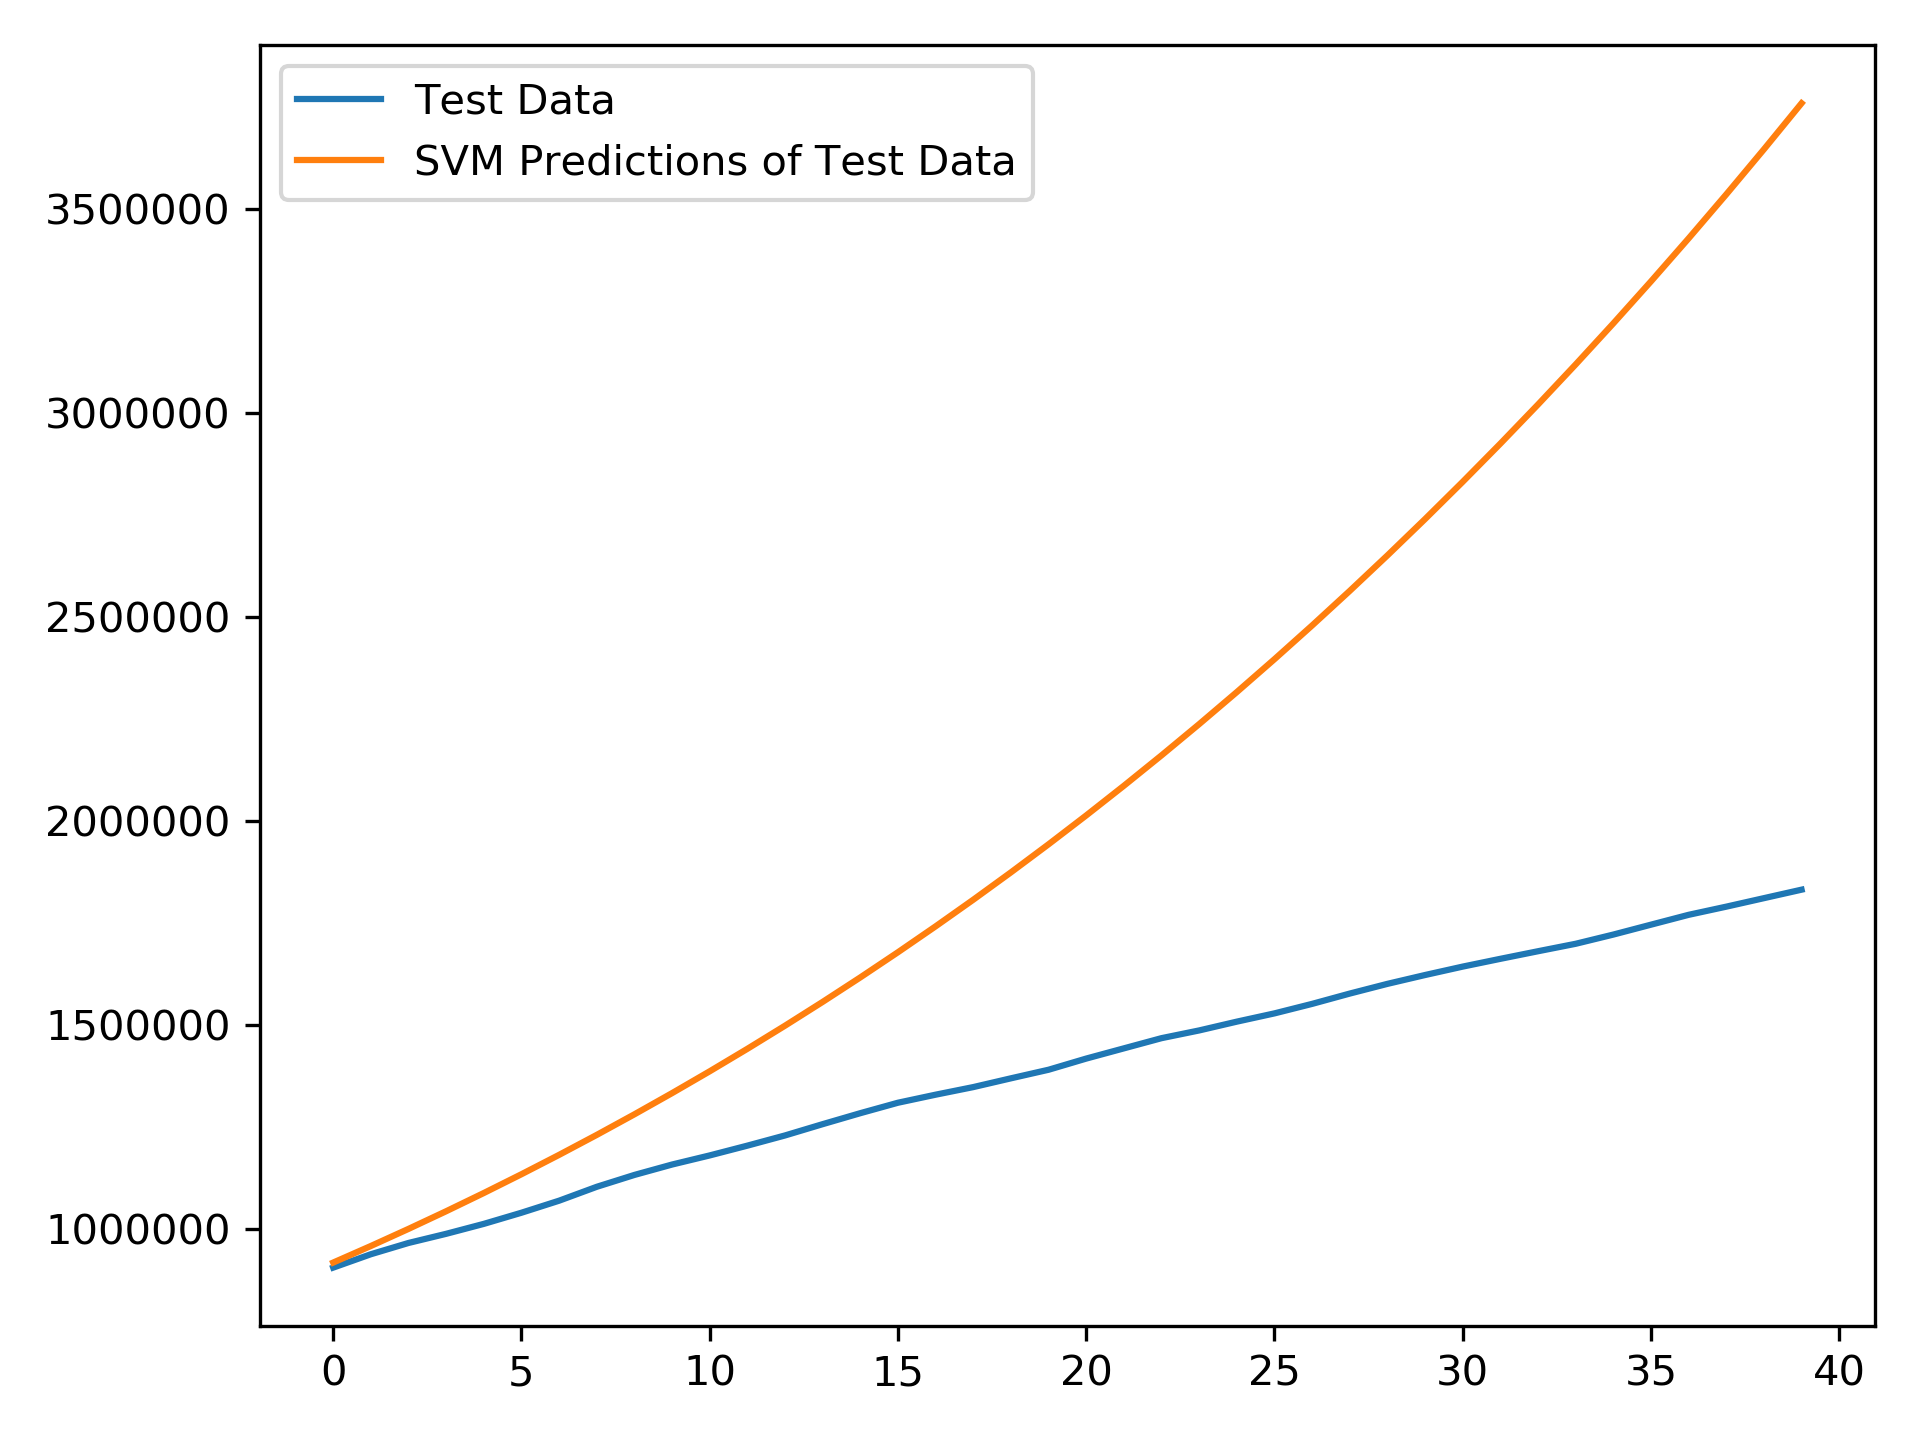

In [62]:
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions of Test Data'])

In [63]:
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

MAE: 709919.3579068469
MSE: 834874436695.4641


Seen from the 2 graphs,  we know that by applying polynomial kernel, we actually got a similar result with polynomial regression. We also tried all kinds of parameters shown above and finally select "shrinking=True, kernel='poly', gamma=0.01, epsilon=0.1, degree=4, C=0.01" as our final parameters. Also, we can see, when we select a higher degree and higher gamma, the time cost of training process increases rapidly.

## Finally, we try to use simple <em>Neural Networks</em> to predict

In [131]:
import torch
import torch.nn.functional as F

class Neural_Network(torch.nn.Module):
    
    def __init__(self, n_feature, n_hidden, n_output):
        super(Neural_Network, self).__init__()
        self.hidden_layer1 = torch.nn.Linear(n_feature, n_hidden)
        #self.hidden_layer2 = torch.nn.Linear(n_hidden, int(n_feature/2))
        self.predict_layer = torch.nn.Linear(n_hidden, n_output)

    def forward(self, x):
        hidden_result1 = self.hidden_layer1(x)
        relu_result1 = F.relu(hidden_result1)
        #hidden_result2 = self.hidden_layer2(relu_result1)
        #relu_result2 = F.relu(hidden_result2)
        predict_result = self.predict_layer(relu_result1)
        return predict_result

In [152]:
# parameters setting
TRAIN_TIMES = 2000
INPUT_FEATURE_DIM = 1
OUTPUT_FEATURE_DIM = 1
NEURON_NUM = 64
LEARNING_RATE = 0.5

In [135]:
#transform all the data into tensor
nn_train_x = torch.unsqueeze(torch.Tensor(X_train_confirmed.reshape(-1)), dim=1)
nn_train_y = torch.unsqueeze(torch.Tensor(y_train_confirmed), dim=1)
nn_test_x = torch.unsqueeze(torch.Tensor(X_test_confirmed.reshape(-1)), dim=1)
nn_test_y = torch.unsqueeze(torch.Tensor(y_test_confirmed), dim=1)

nn_future_forcast = torch.unsqueeze(torch.Tensor(future_forcast.reshape(-1)), dim=1)

In [156]:
nn_model = Neural_Network(n_feature=INPUT_FEATURE_DIM, n_hidden=NEURON_NUM, n_output=OUTPUT_FEATURE_DIM)
print(nn_model)
optimizer = torch.optim.Adam(nn_model.parameters(), lr=LEARNING_RATE)
loss_func = torch.nn.MSELoss()

start_time = datetime.datetime.now() 
for i in range(TRAIN_TIMES):
    prediction = nn_model(nn_train_x)

    loss = loss_func(prediction, nn_train_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
end_time = datetime.datetime.now() 
print("The time cost for training is {}".format(end_time - start_time))

Neural_Network(
  (hidden_layer1): Linear(in_features=1, out_features=64, bias=True)
  (predict_layer): Linear(in_features=64, out_features=1, bias=True)
)
The time cost for training is 0:00:03.133615


<IPython.core.display.Javascript object>


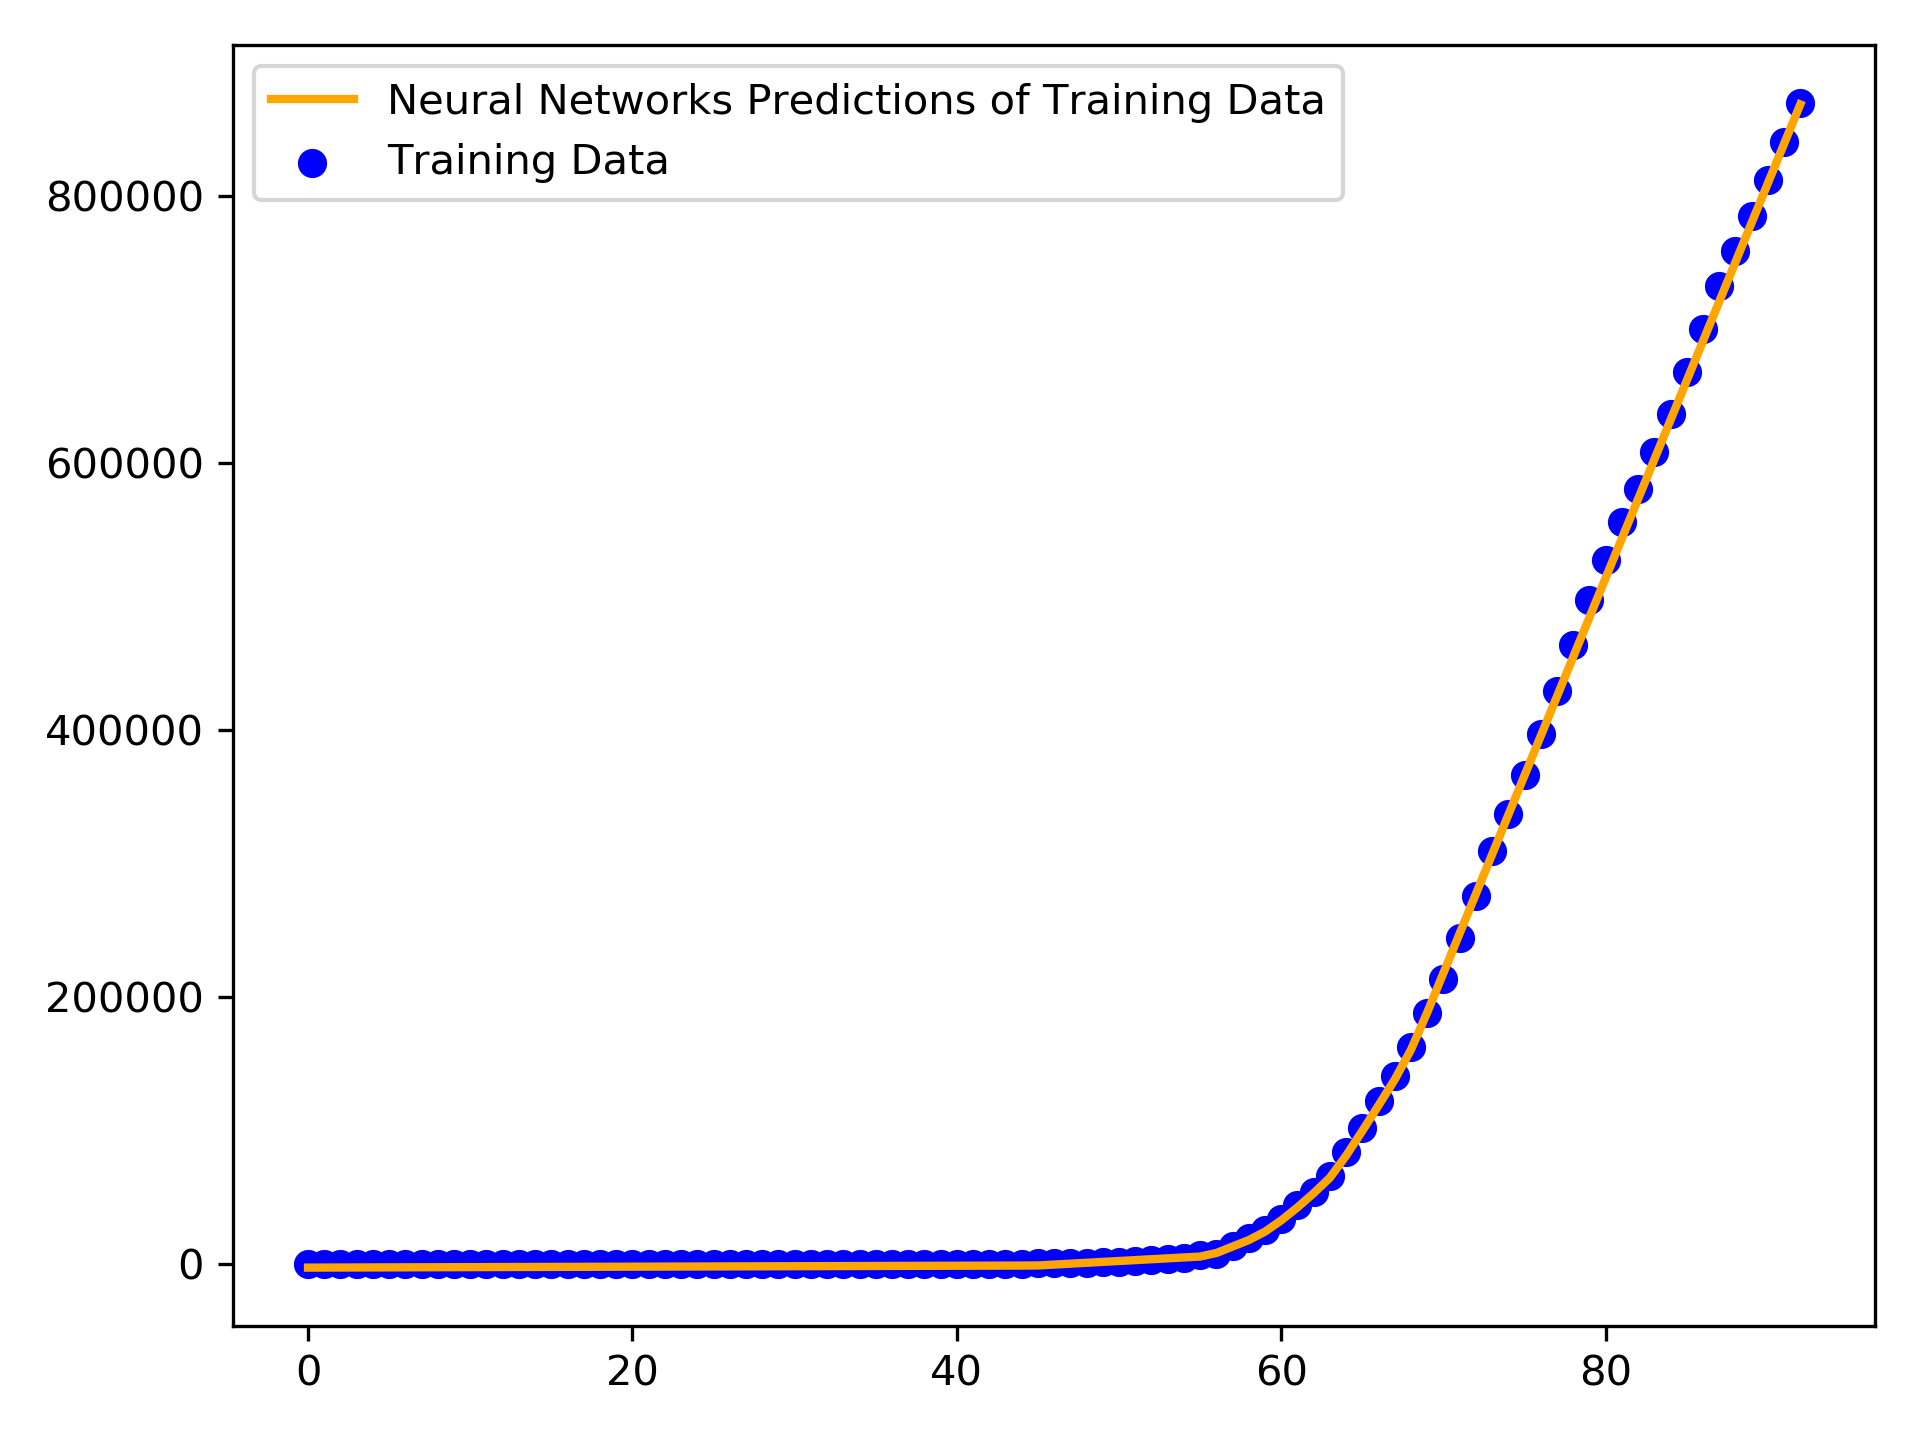

In [157]:
plt.cla()
plt.scatter(nn_train_x.numpy(), nn_train_y.numpy(), c='blue')
# plot the real-time prediction
plt.plot(nn_train_x.numpy(), nn_model(nn_train_x).data.numpy(), c='orange', lw='2')
plt.legend(['Neural Networks Predictions of Training Data', 'Training Data'])

In [159]:
nn_test_pred = nn_model(nn_test_x).data.numpy()
nn_future_pred = nn_model(nn_future_forcast).data.numpy()

<IPython.core.display.Javascript object>


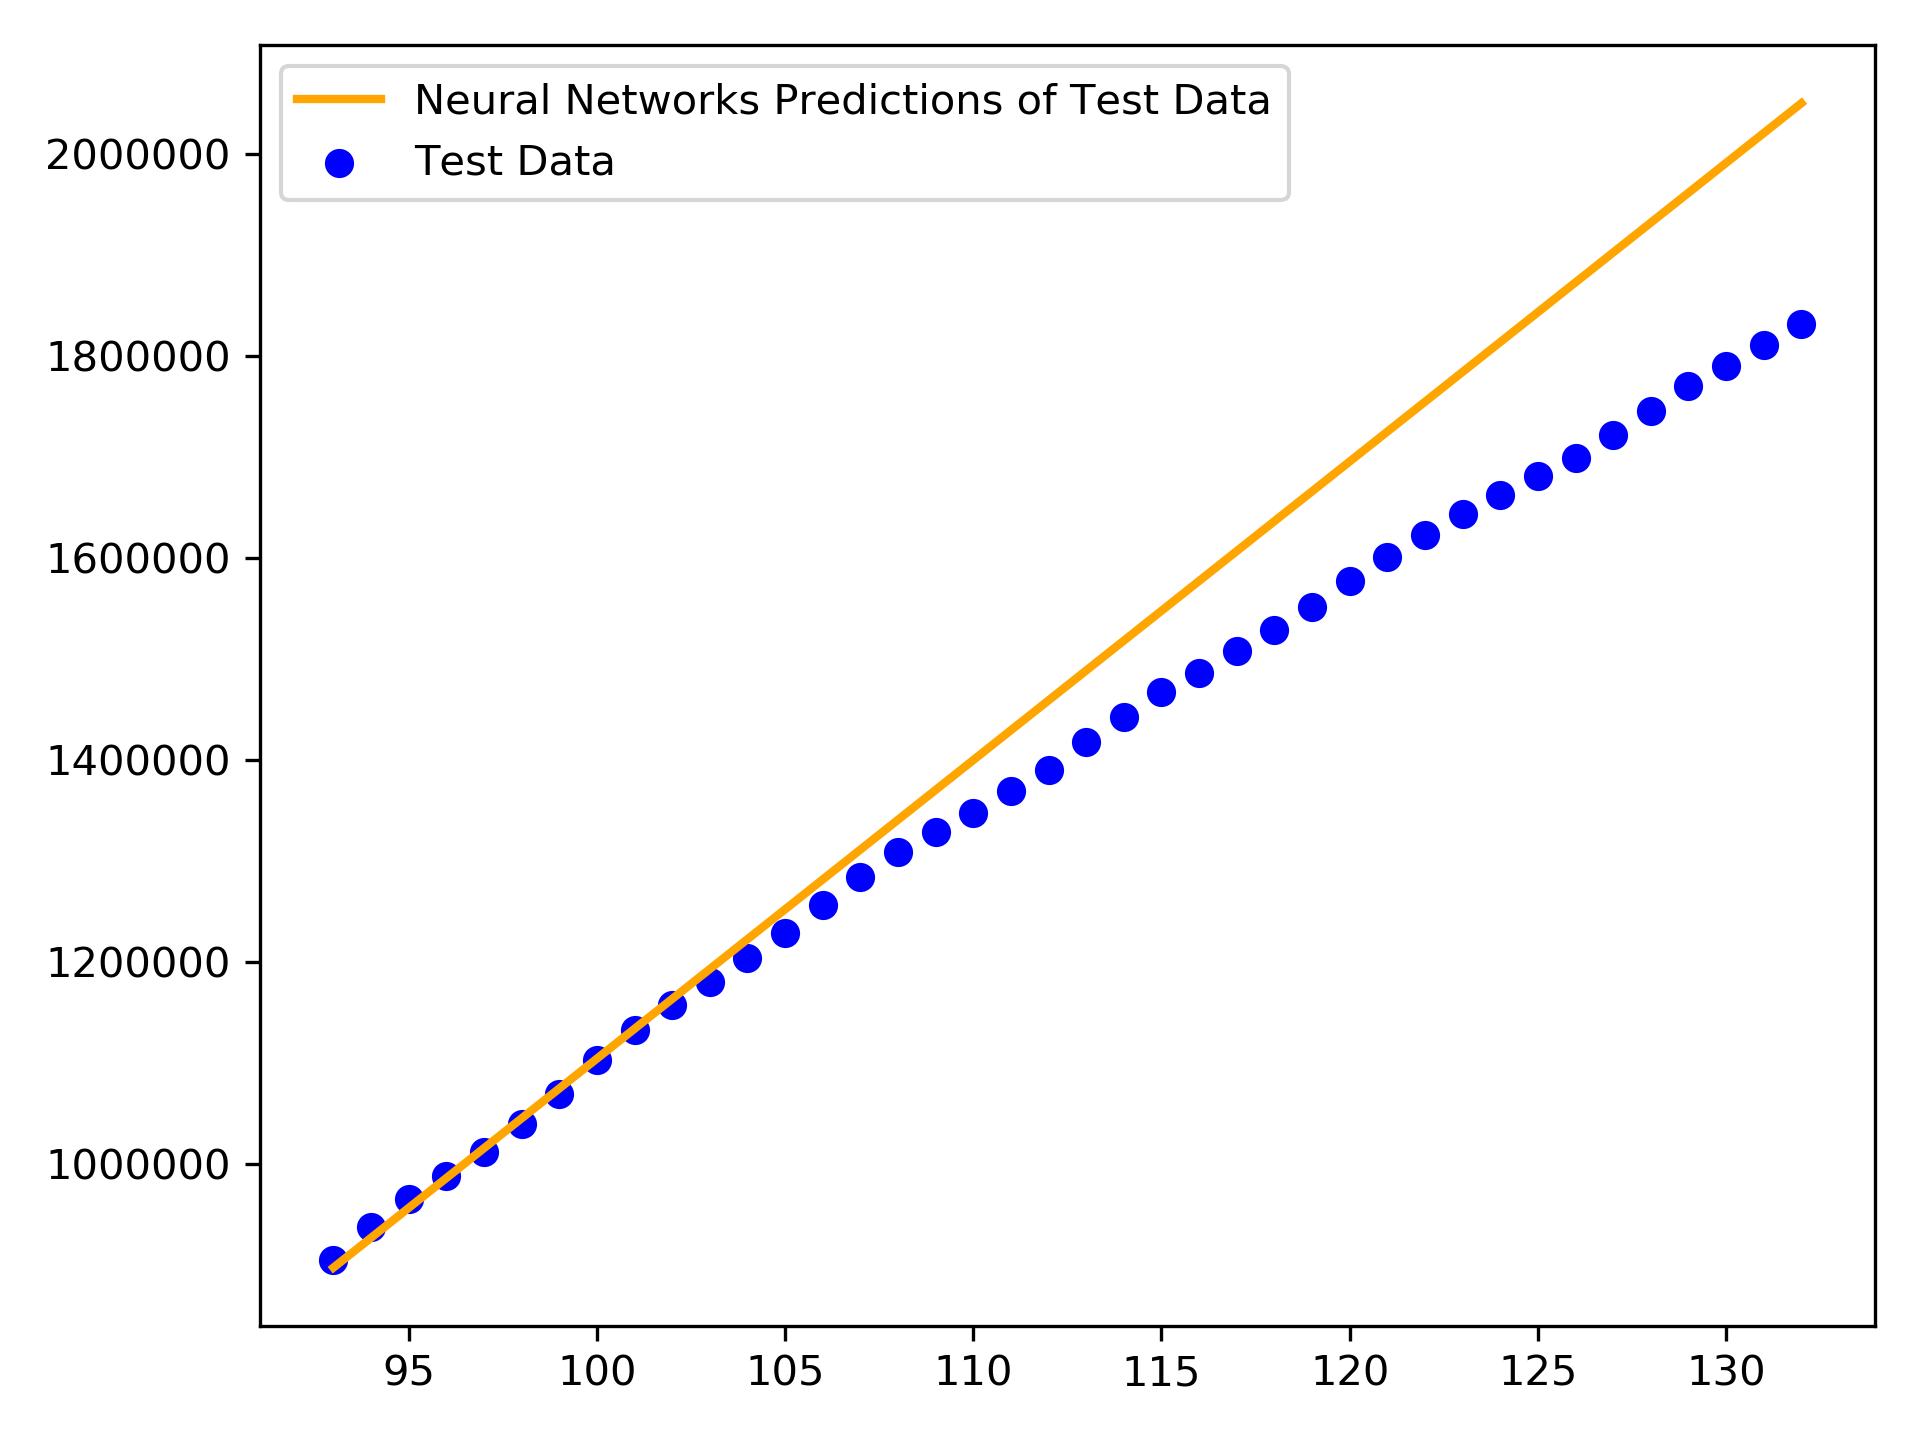

In [161]:
plt.cla()
plt.scatter(X_test_confirmed, y_test_confirmed, c='blue')
# plot the real-time prediction
plt.plot(nn_test_x.numpy(), nn_test_pred, c='orange', lw='2')
plt.legend(['Neural Networks Predictions of Test Data', 'Test Data'])

In [162]:
print('MAE:', mean_absolute_error(nn_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(nn_test_pred, y_test_confirmed))

MAE: 81076.54375
MSE: 11471369647.338282


As we can see both intuitively and quantitatively, the neural networks performs best but also notice that the training process is the most time-consuming among these methods.

## Draw all the predictions we got

<IPython.core.display.Javascript object>


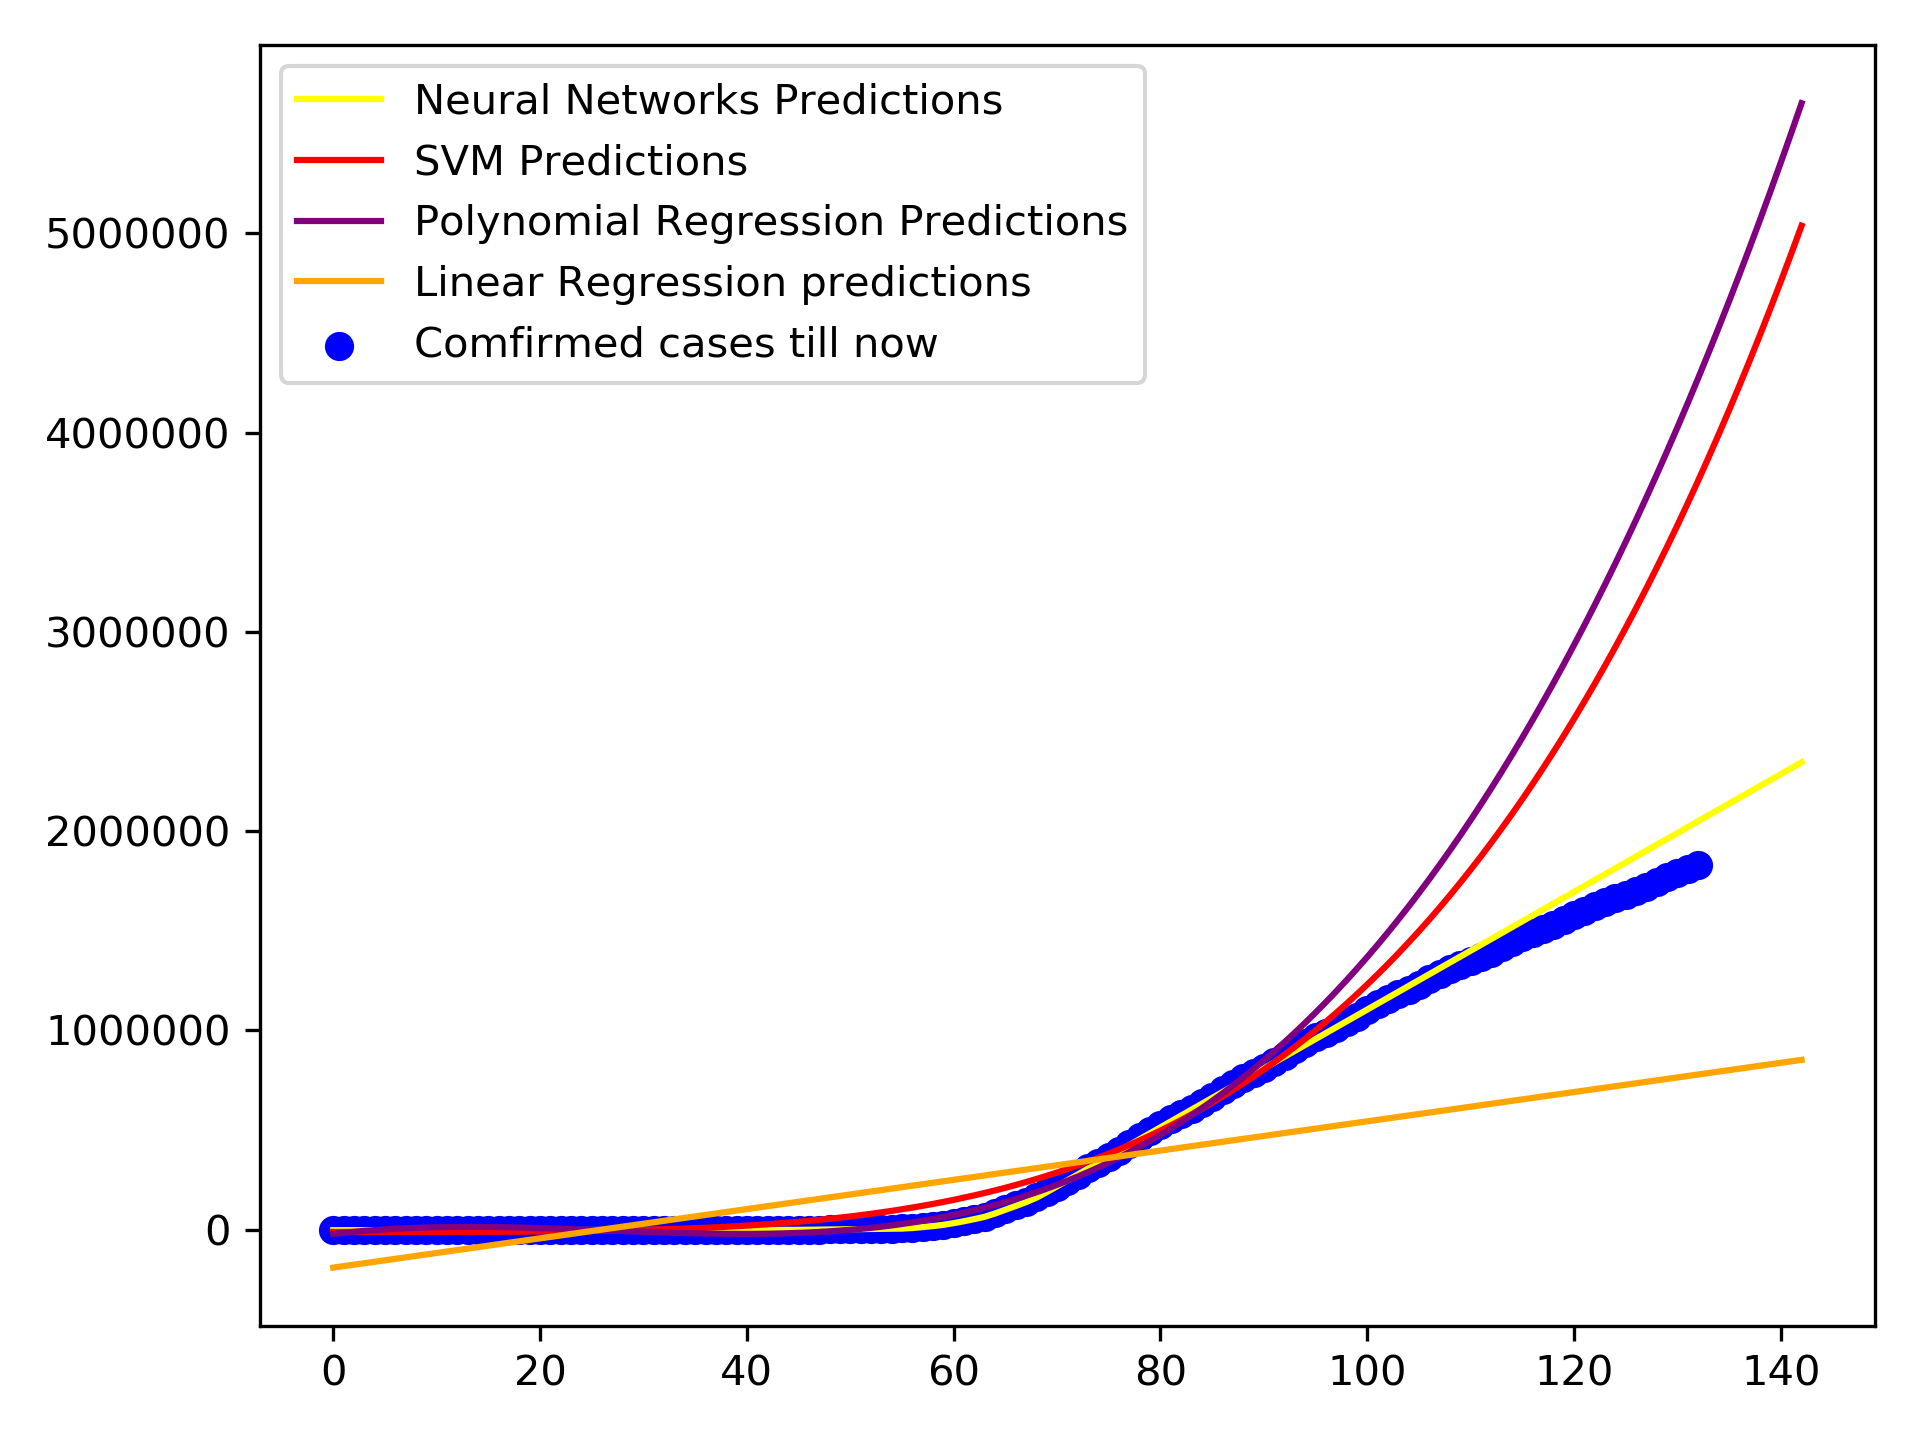

In [172]:
plt.cla()
plt.scatter(future_forcast[:-10], us_cases, c = 'blue')
# plot the NN prediction
plt.plot(future_forcast, nn_future_pred, c = 'yellow')
# plot the SVM prediction
plt.plot(future_forcast, svm_future_pred, c = 'red')
# plot the polynomial prediction
plt.plot(future_forcast, poly_future_pred, c = 'purple')
#plot the linear regression prediction
plt.plot(future_forcast, linear_future_pred, c = 'orange')

plt.legend(['Neural Networks Predictions', 'SVM Predictions', 'Polynomial Regression Predictions', 'Linear Regression predictions','Comfirmed cases till now'])
